# Forecast Proportion of West Java Society Staying Put at Home During COVID-19 Pandemic

by Suwarti

# Use Case

- Use Case Summary
- Objective Statement:
  * During the COVID-19 pandemic Facebook released data on 'Movement Range Maps’. Data contains two main information, there are data on changes in movements of society and proportion of society staying put at home. 
  * This case has some Objective Statement based on the data:
   * Build model to forecast proportion of West Java society staying put at home in the next 2 weeks.
   * Recommendation to treat West Java society based on forecasting model.

- Challenges:
  * Large size of data, can not maintain by excel spreadsheet.
  * Need several coordination from each department.

- Methodology / Analytic Technique:
  * Descriptive analysis
  * Graph analysis
  * Machine learning model

- Business Benefit:
  * Get behaviour data from proportion of West Java society staying put at home.
  * Know how to treat West Java society based on forecasting model.

- Expected Outcome:
  * Machine learning model that forecast proportion of West Java society staying put at home in the next 2 weeks.
  * Recommendation to treat West Java society based on forecasting model.


# Business Understanding

- During the COVID-19 pandemic Facebook released data on 'Movement Range Maps’. Data contains two main information, there are data on changes in movements of society and proportion of society stay at home. 
- This case has some Objective Statement using the data:
 * Build model to forecast proportion of West Java society staying put at home in the next 2 weeks.
 * Recommendation to treat West Java society based on forecasting model.



# Data Understanding

- Source Data: https://data.humdata.org/dataset/movement-range-maps
- These data sets are intended to inform researchers and public health experts about how populations are responding to physical distancing measures. In particular, there are two metrics, Change in Movement and Stay Put, that provide a slightly different perspective on movement trends. Change in Movement looks at how much people are moving around and compares it with a baseline period that predates most social distancing measures, while Stay Put looks at the fraction of the population that appear to stay within a small area during an entire day.
- Data of Movement Range Maps from 01 March 2020 to 31 December 2020.
- The dataset has 9 columns and 5,229,342 rows.
- Data is provided in one global tab-delimited text file. 	

- Data Dictionary:
 * ds: Date stamp for movement range data row in YYYY-MM-DD form
 * country: Three-character ISO-3166 country code
 * polygon_source: Source of region polygon, either “FIPS” for U.S. data or “GADM” for global data
 * polygon_id: Unique identifier for region polygon, either numeric string for U.S. FIPS codes or alphanumeric string for GADM regions
 * polygon_name: Region name
 * all_day_bing_tiles_visited_relative_change: Positive or negative change in movement relative to baseline
 * all_day_ratio_single_tile_users: Positive proportion of users staying put within a single location
 * baseline_name: When baseline movement was calculated pre-COVID-19
 * baseline_type: How baseline movement was calculated pre-COVID-19


# Data preparation 

- Code Used:
 * Python Version: 3.7.6
 * Packages: Pandas, Numpy, Matplotlib, Seaborn, Sklearn, Statsmodels, Itertools, and Fbprophet.	


In [34]:
#Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from statsmodels.tsa.seasonal import seasonal_decompose

import json
import ast
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.serialize import model_to_json, model_from_json

import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [35]:
#Import Dataset

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
df1 = pd.read_csv('drive/My Drive/movement-range-data-2020-03-01--2020-12-31.txt', sep='\t')

In [37]:
#Check Dataset

df1.head()

,ds,country,polygon_source,polygon_id,polygon_name,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users,baseline_name,baseline_type
0,2020-03-01,AGO,GADM,AGO.10.10_1,Lubango,-0.02992,0.18751,full_february,DAY_OF_WEEK
1,2020-03-02,AGO,GADM,AGO.10.10_1,Lubango,0.06746,0.10521,full_february,DAY_OF_WEEK
2,2020-03-03,AGO,GADM,AGO.10.10_1,Lubango,0.05873,0.11397,full_february,DAY_OF_WEEK
3,2020-03-04,AGO,GADM,AGO.10.10_1,Lubango,0.01288,0.10492,full_february,DAY_OF_WEEK
4,2020-03-05,AGO,GADM,AGO.10.10_1,Lubango,0.02753,0.11056,full_february,DAY_OF_WEEK


In [38]:
df1.shape

(5229342, 9)

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5229342 entries, 0 to 5229341
Data columns (total 9 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   ds                                          object 
 1   country                                     object 
 2   polygon_source                              object 
 3   polygon_id                                  object 
 4   polygon_name                                object 
 5   all_day_bing_tiles_visited_relative_change  float64
 6   all_day_ratio_single_tile_users             float64
 7   baseline_name                               object 
 8   baseline_type                               object 
dtypes: float64(2), object(7)
memory usage: 359.1+ MB


In [40]:
df1.describe()

,all_day_bing_tiles_visited_relative_change,all_day_ratio_single_tile_users
count,5.229342e+06,5.229342e+06
mean,-1.118869e-01,2.350320e-01
std,1.841127e-01,8.914140e-02
min,-1.000000e+00,2.369000e-02
25%,-2.121400e-01,1.734300e-01
50%,-8.750000e-02,2.184400e-01
75%,6.130000e-03,2.775500e-01
max,3.140840e+00,8.419700e-01


# Data Cleansing

The data contains region name of society from all over the world. However we only analyze data from the West Java society. Therefore we remove another region from our analysis.



In [41]:
df1 = df1[(df1.country == 'IDN')]
df1 = df1[(df1.polygon_name == 'Bandung') | (df1.polygon_name == 'Bandung Barat') | (df1.polygon_name == 'Bekasi') | (df1.polygon_name == 'Bogor') | (df1.polygon_name == 'Ciamis') | (df1.polygon_name == 'Cianjur') | (df1.polygon_name == 'Cirebon') | (df1.polygon_name == 'Garut') | (df1.polygon_name == 'Indramayu') | (df1.polygon_name == 'Karawang') | (df1.polygon_name == 'Kuningan') | (df1.polygon_name == 'Majalengka') | (df1.polygon_name == 'Pangandaran') | (df1.polygon_name == 'Purwakarta') | (df1.polygon_name == 'Subang') | (df1.polygon_name == 'Sukabumi') | (df1.polygon_name == 'Sumedang') | (df1.polygon_name == 'Tasikmalaya') | (df1.polygon_name == 'Kota Bandung') | (df1.polygon_name == 'Banjar') | (df1.polygon_name == 'Kota Bekasi') | (df1.polygon_name == 'Kota Bogor') | (df1.polygon_name == 'Cimahi') | (df1.polygon_name == 'Kota Cirebon') | (df1.polygon_name == 'Kota Cirebon') | (df1.polygon_name == 'Depok') | (df1.polygon_name == 'Kota Sukabumi') | (df1.polygon_name == 'Kota Tasikmalaya')]

The dataset has 9 columns. To forecast proportion of West Java society staying put at home, we just need three columns. These columns are date stamp, region name, and positive proportion of users staying put within a single location. Therefore we only analyze three columns and we remove another columns.


In [42]:
df1 = df1[['ds', 'polygon_name', 'all_day_ratio_single_tile_users']]

Format of column date stamp is object. Therefore we have to convert to datetime format.


In [43]:
df1['ds'] = pd.to_datetime(df1['ds'])

In [44]:
print(df1["ds"].min())
print(df1["ds"].max())
print("The data is from 01 March 2020 to 31 December 2020 ")

2020-03-01 00:00:00
2020-12-31 00:00:00
The data is from 01 March 2020 to 31 December 2020 


In [45]:
# fix dataframe to neccessary format

def fix_dataframe(data):  
    df = data
    df.columns = ['ds', 'polygon_name', 'all_day_ratio_single_tile_users']
    df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    df = df[['ds','all_day_ratio_single_tile_users']].set_index(['ds'])
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df_ds = df.groupby(by = ['ds'])['y'].mean().index
    df_y = df.groupby(by = ['ds'])['y'].mean().values
    df_ts = pd.DataFrame({"ds": df_ds, "y": df_y})
    return df_ts

In [46]:
# fix data

fix_data_ts = fix_dataframe(df1)

In [47]:
fix_data_ts.shape

(306, 2)

In [48]:
fix_data_ts.head()

,ds,y
0,2020-03-01,0.188980
1,2020-03-02,0.158907
2,2020-03-03,0.167533
3,2020-03-04,0.182845
4,2020-03-05,0.179588


# Exploratory Data Analysis

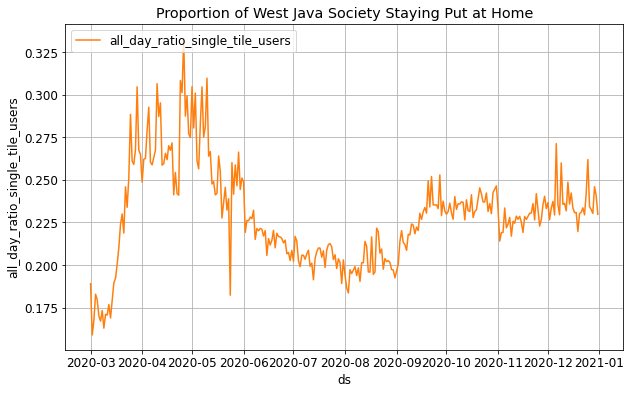

In [49]:
# distribution of the data

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(fix_data_ts.ds, fix_data_ts.y, color='tab:orange', label='all_day_ratio_single_tile_users')

# Same as above
ax.set_xlabel('ds')
ax.set_ylabel('all_day_ratio_single_tile_users')
ax.set_title('Proportion of West Java Society Staying Put at Home')
ax.grid(True)
ax.legend(loc='upper left');

From the graph, we can see that the data is non-linear trends. And there is an extreme pattern in the first 3 months of the data.


# Modeling Data: Prophet

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- From exploratory data analysis, we can see that the data is non-linear trends. Therefore we choose the Prophet model.


Split the data into train and tests sets with a test size of 20%.


In [50]:
# Training and Testing Data

train_size = int(len(fix_data_ts) * 0.80) #disini pakenya 80%
test_size = len(fix_data_ts) - train_size
print(train_size, test_size)

244 62


In [51]:
# Training Data

fix_data_ts.iloc[:245]

,ds,y
0,2020-03-01,0.188980
1,2020-03-02,0.158907
2,2020-03-03,0.167533
3,2020-03-04,0.182845
4,2020-03-05,0.179588
...,...,...
240,2020-10-27,0.236129
241,2020-10-28,0.230143
242,2020-10-29,0.242728
243,2020-10-30,0.244509


In [52]:
# Testing Data

fix_data_ts.iloc[245:] 

,ds,y
245,2020-11-01,0.233127
246,2020-11-02,0.214067
247,2020-11-03,0.219023
248,2020-11-04,0.219187
249,2020-11-05,0.233520
...,...,...
301,2020-12-27,0.232564
302,2020-12-28,0.230355
303,2020-12-29,0.246014
304,2020-12-30,0.240814


In [53]:
# Split Data

train, test = fix_data_ts.iloc[:215], fix_data_ts.iloc[214:]

In [54]:
# function to automate model training
# function to do parameter tuning

def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

# funtion to test crossvalidation 

def single_cv_run(history_df, metrics, param_dict):
    model = Prophet(**param_dict, daily_seasonality=True)
    model.fit(history_df)
    df_cv = cross_validation(model, initial='100 days', period='16 days', horizon = '32 days') # ini parameter crossvalidation untuk prophet
    df_p = performance_metrics(df_cv).mean().to_frame().T
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

- I test crossvalidation using parameter:
 * Initial= 100 days
From exploratory data analysis , we can see that there is an extreme pattern in the first 3 months of the data. Therefore I choose initial= 100 days.
 * Horizon = 32 days
From references that I read, horizon is usually one third from the initial. Therefore I choose initial= 32 days.
 * Period= 16 days.
From references that I read, period is usually one half from the horizon. Therefore I choose period = 16 days.


In [55]:
# define parameter

param_grid = {'changepoint_prior_scale': [0.05, 0.5],
              'changepoint_range': [0.05, 0.5],
              'seasonality_mode': ['multiplicative'],
              'growth': ['linear'],
              'yearly_seasonality': [2,5]}


And then I do hyperparameter tuning using parameter RMSE, horizon, and some parameter default from prophet model.


In [56]:
# hyperparameter tuning

params_df = create_param_combinations(**param_grid)

metrics = ['horizon', 'rmse', 'params'] 
results = []
for i in params_df.values:
    param_dict = dict(zip(params_df.keys(), i))
    cv_df = single_cv_run(train, metrics, param_dict)
    results.append(cv_df)

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-06-11 00:00:00 and 2020-08-30 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
# get result and parameter to dataframe

res_df = pd.concat(results).reset_index(drop=True)
best_param = res_df.loc[res_df['rmse'] == min(res_df['rmse']), ['params']]


In [58]:
# check result

res_df

,horizon,rmse,params
0,18 days,0.0344798,"{'changepoint_prior_scale': 0.05, 'changepoint..."
1,18 days,0.0963561,"{'changepoint_prior_scale': 0.05, 'changepoint..."
2,18 days,0.0327597,"{'changepoint_prior_scale': 0.05, 'changepoint..."
3,18 days,0.0204024,"{'changepoint_prior_scale': 0.05, 'changepoint..."
4,18 days,0.0447819,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
5,18 days,0.243879,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
6,18 days,0.0227684,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
7,18 days,0.113806,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [59]:
# show best param

best_param.values[0][0]

"{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.5, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'yearly_seasonality': 5}"

- And then I do hyperparameter tuning using parameter RMSE, horizon, and some parameter default from prophet model.
- From hyperparameter tuning, we can get best parameter for our model.
- Best  parameter based on the lowest RMSE.


# Evaluating Model

- Root Mean Squared Error (RMSE) represents the sample standard deviation of the differences between predicted values and observed values
- RMSE is one of metric for evaluating time series forecasting algorithms.  
- Lower values of RMSE indicate better fit.


In [60]:
# show rmse

res_df["rmse"].min()

0.020402353641952704

RMSE of our model is 0.02. Meanwhile the actual data is proportion format (between 0 and 1). Therefore the model is better fit.

# Forecasting

- We get best parameter from training data before. We use these best parameter for forecasting model.
- Forecast proportion of West Java society staying put at home in the next 2 weeks 
(from 1 January 2021 to 14 January 2021). 


In [61]:
# function to fit the model

def model_fit(data):
    model = Prophet(changepoint_prior_scale=0.5, 
                    changepoint_range=0.5,  
                    seasonality_mode='multiplicative', 
                    growth='linear',
                    yearly_seasonality=5)
    return model.fit(data)

In [62]:
# function to forecast

def forecast(period, models):
    model = models
    forecast = model.make_future_dataframe(periods=period, freq='D')
    forecast = model.predict(forecast)
    forecast['ds'] = forecast['ds'].astype(str)
    return forecast[['ds', 'yhat']].tail(period)

In [63]:
# fit tuned model

model = model_fit(fix_data_ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
# forecast 

cast = forecast(14, model)

In [65]:
# show forecast

cast

,ds,yhat
306,2021-01-01,0.244173
307,2021-01-02,0.237425
308,2021-01-03,0.248654
309,2021-01-04,0.232442
310,2021-01-05,0.240823
311,2021-01-06,0.240638
312,2021-01-07,0.243334
313,2021-01-08,0.248264
314,2021-01-09,0.241574
315,2021-01-10,0.253220


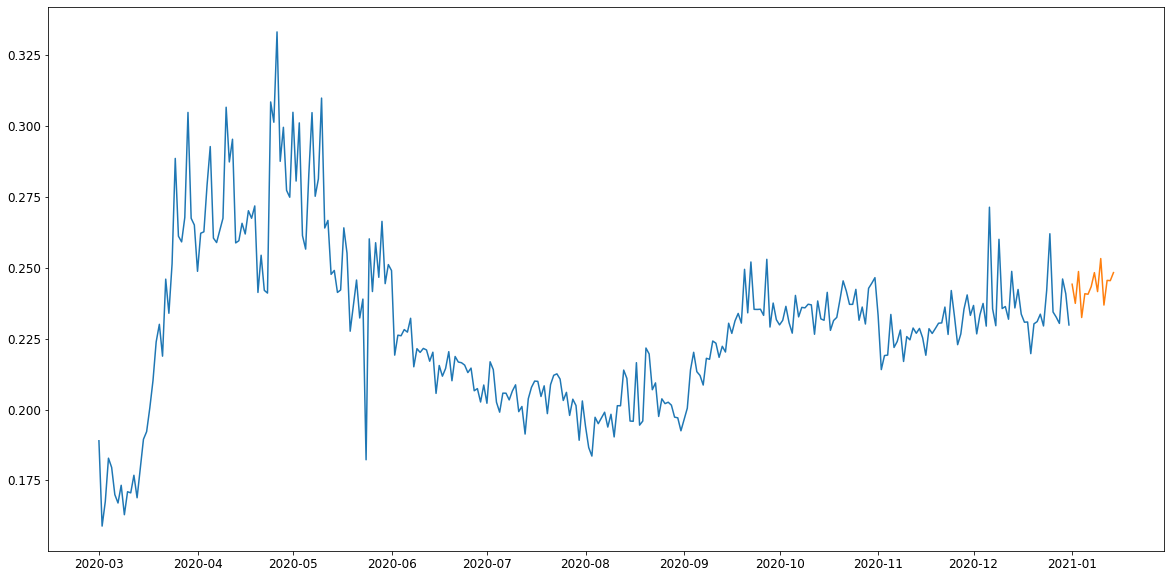

In [66]:
# plot the forecasted data

plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(fix_data_ts["ds"]).dt.date, fix_data_ts["y"])
plt.plot(pd.to_datetime(cast["ds"]).dt.date, cast["yhat"])
plt.show()

# Recommendation

Average of proportion staying put at home in the next 2 weeks is around 0.2. It shows that the proportion of staying put at home is low. It means that mobility of society is high. The government needs to take some planning to anticipate some possible happen.
- The government needs to implement strict health protocols to reduce the spread of COVID-19.
- The government needs to prepare the availability of hospitals.
- The government needs to prepare the availability of medicines.
- The government needs to prepare social compensation for society.

